### Implementing Cross-Entropy Method for CartPole Example

Importing necessary dependencies:

In [5]:
import random
from collections import namedtuple

import numpy as np
import pandas as pd
from plotnine import *
from mizani.formatters import comma_format
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

import gym
import torch
import torch.nn as nn
import torch.optim as optim
# from tensorboardX import SummaryWriter

### The Game 🎮

In [6]:
env = gym.make('CartPole-v0', render_mode='rgb_array')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.


In [7]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Observation space is four continuous measurements.

In [8]:
env.action_space

Discrete(2)

Action space is discrete range from 0 to 1, i.e. left and right.

In [9]:
env.reset()

(array([ 0.01840862, -0.02947938, -0.0427751 ,  0.0463868 ], dtype=float32),
 {})

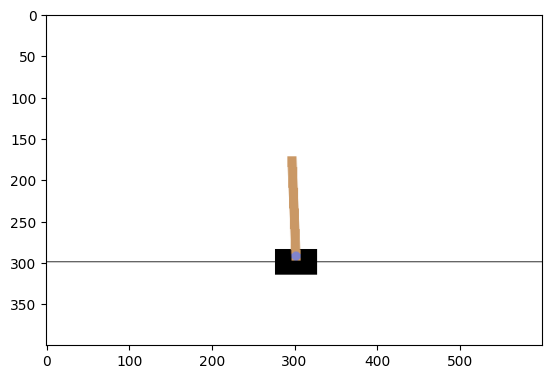

In [10]:
plt.imshow(env.render())

### Training the Agent

Defining hyperparameters for the neural network:

In [11]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

Then, defining the neural network:

In [12]:
class ANN(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            # input size is observation space
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
            # output size is the action space
        )

    def forward(self, x):
        return self.layers(x)

Rather than calculating softmax (which uses exponentiation) and then calculating cross-entropy loss (which uses a logarithm of probabilities), we can use the PyTorch class `nn.CrossEntropyLoss`, which combines both softmax and cross-entropy in a single, more numerically stable expression. `CrossEntropyLoss` requires raw, unnormalized values from the NN (also called logits). The downside of this is that we need to remember to apply softmax every time we need to get probabilities from our NN's output.

In [13]:
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

- _Episode_: This is a single episode stored as total undiscounted reward and a collection of EpisodeStep.
- _EpisodeStep_: This will be used to represent one single step that our agent made in the episode, and it stores the observation from the environment and what action the agent completed. We will use episode steps from "elite" episodes as training data.

In [14]:
torch.tensor([[0.5640, 0.4360]]).data.numpy()[0]

array([0.564, 0.436], dtype=float32)

In [15]:
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    # had to fix this, because new version of gym does not only return the observation
    # but also an empty dictionary in second position of the tuple
    obs, _ = env.reset() # initial observation
    sm = nn.Softmax(dim=1)
    
    while True:
        # Convert the numpy array to a tensor
        obs_v = torch.FloatTensor([obs])
        # pass the observation space to the neural net, which returns action probabilities
        act_probs_v = sm(net(obs_v)) # look like this: tensor([[0.5640, 0.4360]], grad_fn=<SoftmaxBackward0>)
        act_probs = act_probs_v.data.numpy()[0] # converts tensor to this: array([0.564, 0.436], dtype=float32)
        action = np.random.choice(len(act_probs), p=act_probs) # sample from the actions according to output of net
        next_obs, reward, is_done, is_truncated, _ = env.step(action) # take step, get new information
        episode_reward += reward # Add current reward to total reward of episode
        episode_steps.append(EpisodeStep(observation=obs, action=action)) # tuple gets appended to list to store
        # the training data for the neural network later, but still has to be filtered

        # If episode is done (fail or max steps reached -> 200)
        if is_done or is_truncated:
            batch.append(Episode(reward=episode_reward, steps=episode_steps)) # at end of episode, append reward and steps
            episode_reward = 0.0 # reinitialise the environment 
            episode_steps = []
            next_obs, _ = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

Each time the `yield` statement is executed, the current state of the function is saved, and the generator object is returned to the caller along with the current value of batch. When the next batch is requested by the caller (by iterating over the generator object), the function resumes execution from where it left off, with the previous state restored, and continues until the next yield statement is encountered. This process repeats until there are no more batches to yield, at which point the generator object is exhausted and the loop terminates.

Next, write the function that filters the past batches according to the >70th percentile rule:

In [16]:
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch)) # make a list from all rewards
    reward_bound = np.percentile(rewards, percentile) # get the percentile from the rewards
    reward_mean = float(np.mean(rewards)) # get mean of rewards

    train_obs = [] # initialising empty list for each batch means discarding the data each batch
    train_act = [] # i.e. retraining the neural net only on the data from the latest available batch
    for example in batch: # each element in batch is a tuple (episode_reward, episode_steps)
        if example.reward < reward_bound:
            continue # skip the episodes that are below the 70th percentile
        # for each episode above the 70th percentile, add ALL observations and 
        # action pairs from the episode (n=number of steps in episode) to the lists
        train_obs.extend(map(lambda step: step.observation, example.steps))
        train_act.extend(map(lambda step: step.action, example.steps))

    # historical lists are then returned as tensors for the model to learn from
    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

Since `iterate_batches` is a generator function, each call to it returns a new batch, and the enumerate function provides a count for each iteration, which can be used for keeping track of the number of batches processed so far. The enumerate function automatically starts counting at 0 and increments by 1 with each iteration of the loop. This allows the code to keep track of how many batches have been processed and print out the current iteration number as well as other metrics like the loss, mean reward, and reward bound.

In [17]:
env = gym.make('CartPole-v0') # initialise environment
obs_size = env.observation_space.shape[0] # define sizes for NN
n_actions = env.action_space.n

net = ANN(obs_size, HIDDEN_SIZE, n_actions) # Instantiate model
objective = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(net.parameters(), lr=0.01) # define optimizer and learn rate

loss_history = [] # some lists for storage of the performance metrics
reward_m_history = []
reward_b_history = []

# enumerate works, because it's a generator function, see text above
for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    '''
    Main loop that trains the agent (neural network) with data from each batch
    '''
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE) # get training data from each batch in the top 30%
    optimizer.zero_grad()
    action_scores_v = net(obs_v) # get probabilities (linear output of net)
    loss_v = objective(action_scores_v, acts_v) # calculate loss function as the cross entropy 
    # of the probabilities from the net and the actions from the top 30% that were taken
    loss_v.backward() # gradients
    optimizer.step()

    if iter_no % 10 == 0:
        print(f"Batch No {iter_no}: loss={loss_v.item()}, reward_mean={reward_m}, reward_bound={reward_b}")
    
    # Store the values for chart
    loss_history.append(loss_v.item())
    reward_m_history.append(reward_m)
    reward_b_history.append(reward_b)

    # train until the mean of the past 10 batches is about 200
    # 200 is the level defined by OpenAI, as the max episodes for CartPole
    if int(np.mean(reward_m_history[-5:])) == 200: 
        print('Solved!')
        break

C:\Users\mathi\AppData\Local\Temp\ipykernel_24012\1470026040.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)


Batch No 0: loss=0.6856364607810974, reward_mean=22.0625, reward_bound=28.5
Batch No 10: loss=0.5838582515716553, reward_mean=48.125, reward_bound=53.5
Batch No 20: loss=0.5515851378440857, reward_mean=128.375, reward_bound=149.5
Batch No 30: loss=0.5363014936447144, reward_mean=181.75, reward_bound=200.0
Batch No 40: loss=0.5224011540412903, reward_mean=199.625, reward_bound=200.0
Batch No 50: loss=0.5243006944656372, reward_mean=200.0, reward_bound=200.0
Solved!


Explanation why the use of the cross-entropy loss with the action probabilities and the actual actions taken makes sense:

Cross entropy loss is often used in reinforcement learning to train a policy network to take actions that maximize the expected future reward. The network takes as input the current state of the environment and outputs a probability distribution over possible actions. The loss function compares the predicted action probabilities with the actual actions taken in the environment and updates the network's parameters to increase the probability of good actions.

The reason this works is that the objective of the network is to maximize the expected future reward. By assigning higher probabilities to good actions, the network is more likely to take those actions and receive a higher reward in the future. In contrast, assigning lower probabilities to bad actions reduces the chance of the network taking those actions and receiving a lower reward.

Cross entropy loss is a commonly used loss function for classification tasks. It measures the difference between the predicted probabilities and the actual target probabilities. **In reinforcement learning, the actual target probabilities correspond to the actions taken in the environment, while the predicted probabilities correspond to the probabilities assigned by the policy network.**

By minimizing the cross-entropy loss, the network learns to assign higher probabilities to good actions and lower probabilities to bad actions. This, in turn, leads to the network learning a policy that maximizes the expected future reward.

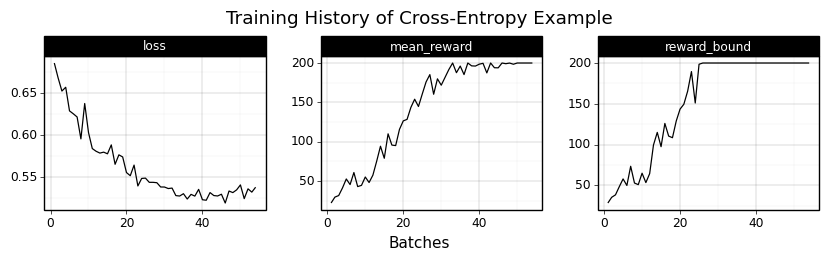

<ggplot: (137340568024)>

In [19]:
training_history = (pd.DataFrame({'loss': loss_history,
                                  'mean_reward': reward_m_history,
                                  'reward_bound': reward_b_history})
                    .assign(batch_num=lambda x: range(1, len(x) + 1))
                    .melt(id_vars='batch_num'))

p = (
    ggplot(data=(training_history),
           mapping=aes(x='batch_num', y='value')) +
    geom_line() +
    facet_wrap('~ variable', scales='free_y') +
    labs(title='Training History of Cross-Entropy Example',
         x='Batches', y=None) +
    theme_linedraw() +
    theme(figure_size=[10, 2], 
          subplots_adjust={'wspace': 0.25})
)

p

In [21]:
p.save(dpi=300, height=2, width=8, filename="python.png")

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 8 x 2 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python.png


Saving the model for later use (Note: This only saves the weights and biases, not the hyperparameters, so this saving mode is for inference only):

In [22]:
torch.save(net.state_dict(), f='trained_model.pt')

### Loading the Trained Agent and Playing Cartpole

In [23]:
# Defining the environment
env = gym.make('CartPole-v0', render_mode='rgb_array')
obs_size = env.observation_space.shape[0] # define sizes for NN
n_actions = env.action_space.n


# Loading the model
net = ANN(obs_size, HIDDEN_SIZE, n_actions) # instance of model
net.load_state_dict(torch.load("trained_model.pt"))
net.eval()

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.


ANN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [24]:
def play_cartpole(env, net, num_episodes):
    for episode in range(num_episodes):
        episode_reward = 0.0
        steps = 0
        reward = 0.0
        obs, _ = env.reset()
        is_done = False
        is_truncated = False
        
        while not is_done and not is_truncated:
            # convert the numpy array to a tensor
            obs_v = torch.FloatTensor([obs])

            with torch.no_grad():
                # pass the observation space to the neural net, which returns action probabilities
                act_probs_v = nn.Softmax(dim=1)(net(obs_v))
            
            act_probs = act_probs_v.data.numpy()[0]
            action = np.random.choice(len(act_probs), p=act_probs)

            # take a step
            next_obs, reward, is_done, is_truncated, _ = env.step(action)
            steps += 1

            episode_reward += reward
            obs = next_obs

            if steps % 15 == 0:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()

        print(f"Episode {episode + 1}: {episode_reward} reward")
        if episode_reward < 200:
            print("FAIL")
        else:
            print("SUCCESS")

        time.sleep(1)

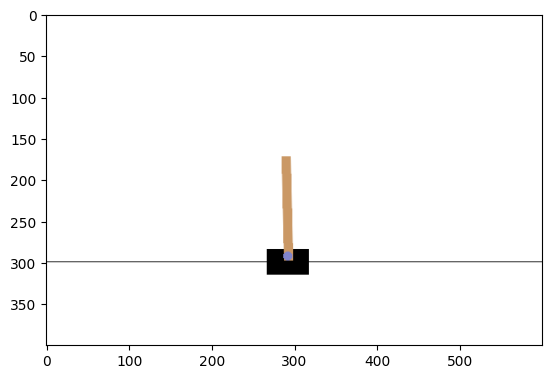

Episode 10: 200.0 reward
SUCCESS


In [25]:
# call the animation function
play_cartpole(env, net, 10)

Compare this to playing with an untrained agent:

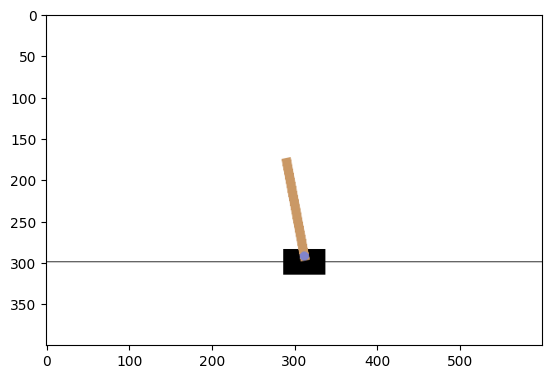

Episode 5: 37.0 reward
FAIL


In [26]:
play_cartpole(env, ANN(obs_size, HIDDEN_SIZE, n_actions), 5)

### My Takeaway from this practical example

The Cross Entropy Method uses an ANN like in a classification setting. Inputs are observations and outputs are the probabilities of certain actions given the inputs. The actions are then sampled according to the probabilities of the ANN, which enables exploration vs. exploitation. After a batch, i.e. a certain number of episodes, all episodes with a reward smaller than some percentile are discarded. In other words, the episodes from the batch that worked out best for the agent are kept and the data (input observations made, output subsequent actions taken) are used as a batch to compute a loss and optimise the ANN's weights. Iteratively, for a number of batches (which each contain a number of episodes which each contain a number of steps, observations, actions and rewards), the model is trained on the top percentiles of the batches, in turn getting better and better at mapping observations to a desirable policy.